# Programación Orientada a Objetos (OOP), decoradores e iteradores
Probablemente podríamos escribir un libro entero sobre programación orientada a objetos (POO) y clases. En esta sesión, nos enfrentamos al difícil reto de encontrar el equilibrio entre amplitud y profundidad. Simplemente hay demasiadas cosas de las que hablar, y muchas de ellas nos llevarían más que todo esta sesión  si las describiéramos a profundidad. Por lo tanto, se intenta brindar una buena visión panorámica de los fundamentos, además de algunas cosas que pueden ser útiles en tu camino para aprender a programar en Python. Tener en cuenta que siempre es necesario revisar la documentación oficial de Python para rellenar algunas dudas que pueden subsistir.

En esta sesión, vamos a cubrir los siguientes temas:
- [Decoradores]()
- [OOP en Python]()
- [Iteradores]()

# Decoradores
En la sesión anterior, `Clase_04_Comprensiones_y_Generadores`, medimos el tiempo de ejecución de varias expresiones.

Para ello, se tuvo que inicializar una variable con el tiempo de inicio y restarlo del tiempo actual después de la ejecución para calcular el tiempo transcurrido. Además, el valor se mostraba en la consola después de cada medición, lo cual se convertía en algo tedioso.

Cada vez que nos encontramos repitiendo cosas, debería sonar una alarma y preguntarnos, ¿Podemos poner ese código en una función y evitar la repetición? La respuesta en la mayoría de los casos es sí, así que veamos un ejemplo:

In [1]:
from time import sleep, time
def f():
    sleep(.3)
def g():
    sleep(.5)
t = time()
f()
print('f took:', time() - t) # f took: 0.3001396656036377
t = time()
g()
print('g took:', time() - t) # g took: 0.5039339065551758

f took: 0.3021383285522461
g took: 0.5007703304290771


En el código anterior, definimos dos funciones, $f()$ y $g()$, que no hacen nada más que dormir (durante 0,3 y 0,5 segundos, respectivamente). Para ello, se utiliza la función $sleep()$ para suspender la ejecución durante el tiempo deseado. Se puede observar cómo la medida de tiempo es bastante precisa. Para evitar repetir este código y esos cálculos, existen diferentes enfoques.

Un primer enfoque potencial podría ser el siguiente:

In [6]:
def f():
    sleep(.3)
def g():
    sleep(.5)
def measure(func):
    t = time()
    func()
    print(func.__name__, 'took:', time() - t)

measure(f)
measure(g)

f took: 0.3006470203399658
g took: 0.5004074573516846


Se ve mucho mejor ahora. Todo el mecanismo de sincronización se ha encapsulado en una función para que no repitamos código. Se imprime el nombre de la función dinámicamente y es bastante fácil de codificar, el problema radica si se quiere pasar algún argumento a la función que medimos. Para ello, se debe reescribir el código de la siguiente manera:

In [7]:
def f(sleep_time=0.1):
    sleep(sleep_time)
def measure(func, *args, **kwargs):
    t = time()
    func(*args, **kwargs)
    print(func.__name__, 'took:', time() - t)
measure(f, sleep_time=0.3)
measure(f, 0.2)

f took: 0.30111074447631836
f took: 0.20041298866271973


Ahora, $f()$ espera ser alimentada con $sleep_time$ (con un valor por defecto de 0.1), por lo que ya no necesitamos $g()$. También tuvimos que cambiar la función $measure()$ para que ahora acepte una función, cualquier argumento posicional de variable y cualquier argumento de palabra clave de variable. De esta forma, llamemos a $measure()$ con lo que llamemos, redirigimos esos argumentos a la llamada a $func()$.

Esto está muy bien, pero podemos llevarlo un poco más lejos. Digamos que de alguna manera queremos tener ese comportamiento de tiempo incorporado en la función $f()$, de modo que sólo podríamos llamarla y tener esa medida tomada. He aquí cómo podríamos hacerlo:

In [9]:
def f(sleep_time=0.1):
    sleep(sleep_time)
def measure(func):
    def wrapper(*args, **kwargs):
        t = time()
        func(*args, **kwargs)
        print(func.__name__, 'took:', time() - t)
    return wrapper
f = measure(f)      # decoration point
f(0.2)              # f took: 0.20372915267944336
f(sleep_time=0.3)   # f took: 0.30455899238586426
print(f.__name__)   # wrapper <- ouch!

f took: 0.2003791332244873
f took: 0.30083131790161133
wrapper


El código anterior probablemente no sea tan sencillo. La magia está en el punto de decoración. Básicamente reasignamos $f()$ con lo que sea devuelto por $measure()$ cuando la llamamos con $f$ como argumento. Dentro de $measure()$, definimos otra función, $wrapper()$, y luego la devolvemos. Así, el efecto neto es que después del punto de decoración, cuando llamamos a $f()$, en realidad estamos llamando a $wrapper()$. Dado que el $wrapper()$, que esa  dentro, está llamando a $func()$, que es $f()$, en realidad estamos cerrando el bucle.

La función wrapper() es, como es lógico, un wrapper. Toma argumentos variables posicionales y de palabra clave y llama a $f()$ con ellos. También realiza el cálculo de la medida del tiempo alrededor de la llamada.

Esta técnica se llama decoración, y $measure()$ es, efectivamente, un decorador. Este paradigma se hizo tan popular y ampliamente utilizado en Python.

Exploremos ahora tres casos: un decorador, dos decoradores, y un decorador que toma argumentos. Primero, el caso de un solo decorador:

In [12]:
# Definimos un decorador
def my_decorator(func):
    def wrapper(*args, **kwargs):
        print("Antes de ejecutar la función")
        result = func(*args, **kwargs)
        print("Después de ejecutar la función")
        return result
    return wrapper

# Aplicando el decorador manualmente
def greet(name):
    print(f"Hola, {name}!")

greet = my_decorator(greet)
greet("Nicolas")

# Aplicando el decorador con la sintaxis @
@my_decorator
def farewell(name):
    print(f"Adiós, {name}!")

farewell("Nicolas")

Antes de ejecutar la función
Hola, Nicolas!
Después de ejecutar la función
Antes de ejecutar la función
Adiós, Nicolas!
Después de ejecutar la función


Básicamente, en lugar de reasignar manualmente la función a lo devuelto por el decorador, anteponemos a la definición de la función la sintaxis especial, *@my_decorator*.

Podemos aplicar múltiples decoradores a la misma función de la siguiente manera:

In [13]:
def deco1(func):
    def wrapper(*args, **kwargs):
        print("Decorador 1: Antes de la función")
        result = func(*args, **kwargs)
        print("Decorador 1: Después de la función")
        return result
    return wrapper

def deco2(func):
    def wrapper(*args, **kwargs):
        print("Decorador 2: Antes de la función")
        result = func(*args, **kwargs)
        print("Decorador 2: Después de la función")
        return result
    return wrapper

# Aplicando los decoradores manualmente
def greet(name):
    print(f"Hola, {name}!")

greet = deco1(deco2(greet))
greet("Nicolas")

# Aplicando los decoradores con la sintaxis @
@deco1
@deco2
def farewell(name):
    print(f"Adiós, {name}!")

farewell("Nicolas")

Decorador 1: Antes de la función
Decorador 2: Antes de la función
Hola, Nicolas!
Decorador 2: Después de la función
Decorador 1: Después de la función
Decorador 1: Antes de la función
Decorador 2: Antes de la función
Adiós, Nicolas!
Decorador 2: Después de la función
Decorador 1: Después de la función


Cuando se aplican múltiples decoradores, es importante prestar atención al orden. En el ejemplo anterior, $func()$ se decora primero con $deco2()$, y el resultado se decora con $deco1()$. Una buena regla general es que cuanto más cerca esté el decorador de la función, se aplicará primero.

Algunos decoradores pueden tomar argumentos. Esta técnica se utiliza generalmente para producir otro decorador (en cuyo caso, el objeto se llamaría fábrica de decoradores).

Veamos la sintaxis y, a continuación, un ejemplo:

In [14]:
def decoarg(arg_a, arg_b):
    def decorator(func):
        def wrapper(*args, **kwargs):
            print(f"Decorador con argumentos: {arg_a}, {arg_b}")
            result = func(*args, **kwargs)
            return result
        return wrapper
    return decorator

# Aplicando el decorador manualmente
def greet(name):
    print(f"Hola, {name}!")

greet = decoarg("Hello", "World")(greet)
greet("Nicolas")

# Aplicando el decorador con la sintaxis @
@decoarg("Goodbye", "World")
def farewell(name):
    print(f"Adiós, {name}!")

farewell("Nicolas")


Decorador con argumentos: Hello, World
Hola, Nicolas!
Decorador con argumentos: Goodbye, World
Adiós, Nicolas!


Como puede ver, este caso es un poco diferente. Primero, se llama a $decoarg()$ con los argumentos dados, y luego se llama a su valor de retorno (el decorador real) con $func()$. Antes de poner otro ejemplo, vamos a arreglar una cosa que nos está molestando. Echa un vistazo a este código de nuestro ejemplo anterior:

In [16]:
def f(sleep_time=0.1):
    sleep(sleep_time)

def measure(func):
    def wrapper(*args, **kwargs):
        t = time()
        func(*args, **kwargs)
        print(func.__name__, 'took:', time() - t)
    return wrapper

f = measure(f)      # decoration point
print(f.__name__)   # wrapper <- ouch!

wrapper


No queremos perder el nombre y el *docstring* de la función original cuando la decoramos. Pero como dentro de nuestro decorador devolvemos *wrapper*, la función decorada, $f()$, es reasignada a éste y por tanto sus atributos originales se pierden, siendo reemplazados por los atributos de *wrapper*. Hay una solución fácil para eso desde el bonito módulo *functools*. Arreglaremos el último ejemplo, y también reescribiremos su sintaxis para usar el operador *@*:

In [17]:
from functools import wraps

def measure(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        t = time()
        func(*args, **kwargs)
        print(func.__name__, 'took:', time() - t)
    return wrapper

@measure
def f(sleep_time=0.1):
    """I'm a cat. I love to sleep! """
    sleep(sleep_time)

f(sleep_time=0.3)                   # f took: 0.3010902404785156
print(f.__name__, ':', f.__doc__)   # f : I'm a cat. I love to sleep!

f took: 0.30007004737854004
f : I'm a cat. I love to sleep! 


Como puedes ver, todo lo que necesitamos hacer es decirle a Python que *wrapper* en realidad envuelve a $func()$ (mediante la función $wraps()$), y puedes ver que el nombre original y el *docstring* se mantienen ahora.

Veamos otro ejemplo. Crearemos un decorador que imprima un mensaje de error cuando el resultado de una función sea mayor que un cierto umbral. Aprovecharemos también para mostrar cómo aplicar dos decoradores a la vez:

In [20]:
def measure(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        t = time()
        result = func(*args, **kwargs)
        print(func.__name__, 'took:', time() - t)
        return result
    return wrapper

def max_result(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        if result > 100:
            print(
                f'Result is too big ({result}). '
                'Max allowed is 100.'
            )
        return result
    return wrapper

@measure
@max_result
def cube(n):
    return n ** 3

print(cube(2))
print(cube(5))

cube took: 0.0
8
Result is too big (125). Max allowed is 100.
cube took: 0.0
125


Se ha mejorado el decorador *measure()*, para que su *wrapper* devuelva ahora el resultado de la llamada a $func()$. El decorador *max_result* también lo hace, pero antes de devolver comprueba que el resultado no sea mayor que 100, que es el máximo permitido. Decoramos $cube()$ con ambos. Primero se aplica *max_result()* y luego *measure()*.

En el resultado podemos ver que se ha separado las dos llamadas con una línea en blanco. En la primera llamada, el resultado es 8, lo que supera la comprobación del umbral. Se mide el tiempo de ejecución y se imprime. Finalmente, imprimimos el resultado (8).

En la segunda llamada, el resultado es 125, por lo que se imprime el mensaje de error, se devuelve el resultado y, a continuación, es el turno de $measure()$, que vuelve a imprimir el tiempo de ejecución y, por último, imprimimos el resultado (125).

Si hubiéramos decorado la función $cube()$ con los mismos dos decoradores pero en distinto orden, el orden de los mensajes impresos también habría sido distinto (como en el siguiente ejemplo).

In [21]:
@max_result
@measure
def cube(n):
    return n ** 3

print(cube(2))
print(cube(5))

cube took: 0.0
8
cube took: 0.0
Result is too big (125). Max allowed is 100.
125


## Una fábrica de decoradores
Vamos a simplificar el ejemplo anterior, volviendo a un único decorador: $max_result()$. El objetivo de ello es que podamos decorar diferentes funciones con diferentes umbrales, sin que tener que escribir un decorador para cada umbral. Por lo tanto, vamos a modificar $max_result()$ para que nos permita decorar funciones especificando el umbral dinámicamente:

In [24]:
def max_result(threshold):
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            result = func(*args, **kwargs)
            if result > threshold:
                print(
                    f'Result is too big ({result}). '
                    f'Max allowed is {threshold}.'
                )
            return result
        return wrapper
    return decorator

@max_result(75)
def cube(n):
    return n ** 3

print(cube(5))
print(cube(3))

Result is too big (125). Max allowed is 75.
125
27


El código anterior muestra cómo escribir una fábrica de decoradores. Si recuerdas, decorar una función con un decorador que toma argumentos es lo mismo que escribir $func = decorator(argA, argB)(func)$, así que cuando decoramos cubo con $max_resultado(75)$, estamos haciendo $cubo = max_resultado(75)(cubo)$.

Vamos a desflozar el codigo paso a paso. Cuando llamamos a $max_resultado(75)$, entramos en su cuerpo. Dentro de él, se define una función $decorator()$, que toma una función como único argumento. Dentro de esa función, se realiza el truco habitual de los decoradores. Definimos $wrapper()$, dentro de la cual comprobamos el resultado de la llamada a la función original. Lo bueno de este enfoque es que, desde el nivel más interno, podemos seguir haciendo referencia tanto a $func$ como a $threshold$, lo que nos permite establecer el umbral de forma dinámica.

La función $wrapper()$ devuelve resultado, $decorator()$ devuelve $wrapper()$, y $max_result()$ devuelve $decorator()$. Esto significa que nuestra llamada $cube = max_result(75)(cube)$ se convierte en $cube = decorator(cube)$. Pero no cualquier $decorador()$, sino uno para el que el umbral tiene un valor de 75. Esto se consigue mediante un mecanismo llamado $decorador()$. Esto se consigue mediante un mecanismo llamado cierre.

Las funciones creadas dinámicamente que son devueltas por otras funciones se denominan $closures$. Su principal característica es que tienen acceso completo a las variables y nombres definidos en el espacio de nombres local en el que se crearon, aunque la función de cierre haya devuelto y terminado de ejecutarse.

El código anterior nos permite utilizar el decorador $max_result()$ con diferentes umbrales, de la siguiente manera:

In [26]:
@max_result(75)
def cube(n):
    return n ** 3
print(cube(8))
print(cube(4))

@max_result(100)
def square(n):
    return n ** 2
print(square(20))
print(square(3))

@max_result(1000)
def multiply(a, b):
    return a * b
print(multiply(50, 45))
print(multiply(21, 13))

Result is too big (512). Max allowed is 75.
512
64
Result is too big (400). Max allowed is 100.
400
9
Result is too big (2250). Max allowed is 1000.
2250
273


Tenga en cuenta que cada decoración utiliza un valor de umbral diferente.

Los decoradores son muy populares en Python. Se utilizan con bastante frecuencia y hacen el código más simple, y más elegante.

# Programación Orientada a Objetos (OOP)
Para definir la programación orientada a objetos (OOP por sus siglas en inglés), vamos a usar la definición de Kindler, E.; Krivy, I. (2011). Object-oriented simulation of systems with sophisticated control (International Journal of General Systems), cuya adaptación a Python es la siguiente:

*La programación orientada a objetos (OOP) es un paradigma de programación basado en el concepto de «objetos», que son estructuras de datos que contienen datos, en forma de atributos, y código, en forma de funciones conocidas como métodos. Una característica distintiva de los objetos es que los métodos de un objeto pueden acceder a los atributos de datos del objeto con el que están asociados y, a menudo, modificarlos (los objetos tienen una noción de «self). En la OOP, los programas de ordenador se diseñan a partir de objetos que interactúan entre sí.*

Python es totalmente compatible con este paradigma ya que todo en Python es un objeto, así que esto demuestra que la programación orientada a objetos no sólo está soportada por Python, sino que es una característica central del lenguaje.

Los dos actores principales de la OOP son los objetos y las clases. Las clases se usan para crear objetos (los objetos son instancias de las clases a partir de las cuales se crearon), así que podríamos verlas como «fábricas de instancias».

Cuando una clase crea objetos, éstos heredan los atributos y métodos de la clase.  Representan elementos concretos del dominio del programa.


## La clase más sencilla de Python
Empezaremos con la clase más sencilla que se puede escribir en Python:

In [4]:
# Creamos la clase Simplest
class Simplest():               # cuando están vacías, las llaves son opcionales
    pass

print(type(Simplest))           # ¿qué tipo es este objeto?
simp = Simplest()               # creamos una instancia de Simplest: simp
print(type(simp))               # ¿qué tipo es este objeto?
print(type(simp) is Simplest)   # ¿es simp una instancia de Simplest

<class 'type'>
<class '__main__.Simplest'>
True


Desglosando el código anterior paso a paso: primeros se ha creado la clase *Simplest* que hemos definido sólo con la instrucción *pass* en su cuerpo, lo que significa que no tiene atributos o métodos personalizados. Los corchetes después del nombre son opcionales si están vacíos. Luego, imprimimos su tipo (`__main__` es el nombre del ámbito en el que se ejecuta el código de nivel superior), y podemos ver que el resultado de esa sentencia *print* es un objeto puesto que las clases son en realidad objetos. Para ser precisos, son instancias de tipo. Explicar este concepto nos llevaría a hablar de metaclases y metaprogramación, conceptos avanzados que requieren un sólido dominio de los fundamentos para ser entendidos y que están fuera del alcance de esta sesión. 

Retornando al ejemplo, se creo la variable *simp*, que representa una instancia de la clase *Simplest*. Podemos notar que la sintaxis para crear una instancia es la misma que la sintaxis para llamar a una función.

Por útlimo, imprimimos a qué tipo pertenece *simp* y verificamos que *simp* es, de hecho, una instancia de *Simplest*.

## Espacios de nombres de clases y objetos
Una vez creado el objeto clase (lo que suele ocurrir cuando se importa el módulo por primera vez), básicamente representa un espacio de nombres (*namespace*). Podemos llamar a esa clase para crear sus instancias. Cada instancia hereda los atributos y métodos de la clase y recibe su propio espacio de nombres. Para recorrer un espacio de nombres basta con utilizar el operador punto $(.)$.

Veámoslo con un ejemplo:

In [3]:
# Creamos la clase Person
class Person:
    species = 'Human'

print(f"{Person.species = }")       # Human
Person.alive = True                 # Añadimos un valor de manera dinámica
print(f"{Person.alive = }")         # True

man = Person()                      # Instancia de la clase Person
print(f"{man.species = }")          # Human (heredado)
print(f"{man.alive = }")            # True (heredado)
Person.alive = False                
print(f"{man.alive = }")            # False (heredado)
man.name = 'Darth'
man.surname = 'Vader'
print(man.name, man.surname)        # Darth Vader

Person.species = 'Human'
Person.alive = True
man.species = 'Human'
man.alive = True
man.alive = False
Darth Vader


En el ejemplo anterior, se ha definido un atributo de clase llamado *species*. Cualquier nombre definido en el cuerpo de una clase se convierte en un atributo que pertenece a esa clase. En el código, también hemos definido *Person.alive*, que es otro atributo de clase. Puedes ver que no hay ninguna restricción para acceder a ese atributo desde la clase. Podemos notar que *man*, que es una instancia de *Person*, hereda ambos, y los refleja instantáneamente cuando cambian.

*man* también tiene dos atributos que pertenecen a su propio espacio de nombres y, por tanto, se denominan atributos de instancia: *name* y *surname*.

Tener en cuenta que los atributos de clase se comparten entre todas las instancias, mientras que los atributos de instancia no; por lo tanto, debes utilizar atributos de clase para proporcionar los estados y comportamientos que compartirán todas las instancias y utilizar atributos de instancia para los datos que serán específicos de cada objeto individual.

## Seguimiento de atributos
Cuando se busca un atributo en un objeto, si no se encuentra, Python extiende la búsqueda a los atributos de la clase que se utilizó para crear ese objeto (y sigue buscando hasta que se encuentra o se llega al final de la cadena de herencia). Esto conduce a un interesante comportamiento de sombra. Veamos un ejemplo:

In [7]:
class Point:
    x = 15
    y = 8

p = Point()                 # Instancia de la clase Point
print(f"{p.x = }")          # 15 (del atributo de clase)
print(f"{p.y = }")          # 8 (del atributo de clase)
p.x = 17                    # p tiene su propio atributo `x`
print(f"{p.x = }")          # 17 (ahora se encuentra en la instancia)
print(f"{Point.x = }")      # 15 (el atributo de clase sigue siendo el mismo)
del p.x                     # eliminamos el atributo de instancia
print(f"{p.x = }")          # 15 (ahora la búsqueda tiene que ir de nuevo para encontrar la clase attr)
p.z = 6                     # hagamos un punto 3D
print(f"{p.z = }")          # 6
try:
    print(f"{Point.z = }")
except AttributeError as e:
    print(e)

p.x = 15
p.y = 8
p.x = 17
Point.x = 15
p.x = 15
p.z = 6
type object 'Point' has no attribute 'z'


El código anterior es muy interesante. Se ha definido una clase llamada *Point* con dos atributos de clase, $x$ e $y$. Cuando creamos una instancia de *Point*, $p$, podemos notar que se puede imprimir tanto $x$ como $y$ desde el espacio de nombres de $p$ ($p.x$ y $p.y$). Lo que sucede cuando hacemos eso es que Python no encuentra ningún atributo $x$ o $y$ en la instancia, y por lo tanto busca en la clase, y los encuentra allí.

Luego, le damos a $p$ su propio atributo $x$ asignando a $p.x = 17$. Este comportamiento puede parecer un poco extraño al principio, pero si lo piensas, es exactamente lo mismo que lo que ocurre en una función que declara $x = 17$ cuando hay un $x = 15$ global fuera. Sabemos que $x = 17$ no afectará al global, y para los atributos de clase y de instancia, es exactamente lo mismo. Después de asignar $p.x = 17$, cuando lo imprimimos, la búsqueda no necesita llegar a los atributos de clase porque $x$ se encuentra en la instancia, así que obtenemos 17 impreso. También imprimimos $Point.x$, que hace referencia a $x$ en el espacio de nombres de la clase, para mostrar que sigue siendo 15.

Continuando con el código, se borra $x$ del espacio de nombres de $p$, lo que significa que, en la siguiente línea, cuando lo imprimamos de nuevo, Python irá de nuevo a buscarlo en la clase, porque ya no se encontrará en la instancia.

Las tres últimas líneas te muestran que asignar atributos a una instancia no significa que se vayan a encontrar en la clase. Las instancias obtienen lo que haya en la clase, pero lo contrario no es cierto.

## El argumento Self
Desde el interior de un método de clase, podemos referirnos a una instancia mediante un argumento especial, llamado $self$ por convención. Este argumento es siempre el primer atributo de un método de instancia. Vamos a examinar este comportamiento junto con la forma en que podemos compartir no sólo atributos, sino métodos con todas las instancias:

In [8]:
class Square:
    side = 14
    def area(self):                 # self es una referencia a una instancia
        return self.side ** 2

sq = Square()                       # Instancia de clase Square
print(f"{sq.area() = }")            # 196 (se encuentra en la clase)
print(f"{Square.area(sq) = }")      # 196 (equivalente a sq.area())
sq.side = 16
print(f"{sq.area() = }")            # 256 (se encuentra en la instancia)

sq.area() = 196
Square.area(sq) = 196
sq.area() = 256


Observa cómo el método $area$ es utilizado por $sq$. Las dos llamadas, $Square.area(sq)$ y $sq.area()$, son equivalentes, y nos enseñan cómo funciona el mecanismo. Se puede pasar la instancia a la llamada del método ($Square.area(sq)$), que dentro del método tendrá el nombre de sí mismo, o puede utilizar una sintaxis más cómodo, $sq.area()$, y Python traducirá eso para usted detrás de escena.

Veamos otro ejemplo más completo:

In [10]:
class Price:
    def final_price(self, vat, discount=0):
        """Returns price after applying vat and fixed discount."""
        return (self.net_price * (100 + vat) / 100) - discount

p1 = Price()
p1.net_price = 100
print(f"{Price.final_price(p1, 20, 10) = }")    # 110 (100 * 1.2 - 10)
print(f"{p1.final_price(20, 10) = }")           # equivalente

Price.final_price(p1, 20, 10) = 110.0
p1.final_price(20, 10) = 110.0


El código anterior muestra que nada nos impide utilizar argumentos al declarar métodos. Podemos usar exactamente la misma sintaxis que usamos con la función, pero tenemos que recordar que el primer argumento siempre será la instancia a la que estará ligado el método. No tenemos que llamarlo necesariamente self, pero es la convención, y este es uno de los pocos casos en los que es muy importante cumplirla.

## Inicializar una instancia
¿Te has dado cuenta de que, antes de llamar a $p1.final_price(...)$ en el código anterior, hemos tenido que asignar $net_price$ a $p1$? Hay una forma mejor de hacerlo. En otros lenguajes, esto se llamaría un constructor, pero en Python, no lo es. En realidad es un inicializador, ya que trabaja sobre una instancia ya creada, y por eso se llama `__init__`. Es un método mágico, que se ejecuta justo después de crear el objeto. Los objetos Python también tienen un método `__new__`, que es el constructor real. En la práctica, no es tan común tener que anularlo; esa es una técnica que se utiliza sobre todo al escribir metaclases que, como hemos mencionado, es un tema bastante avanzado que no exploraremos en esta sesión. Veamos ahora un ejemplo de cómo inicializar objetos en Python:

In [11]:
class Rectangle:
    def __init__(self, side_a, side_b):
        self.side_a = side_a
        self.side_b = side_b
    
    def area(self):
        return self.side_a * self.side_b

r1 = Rectangle(12, 7)
print(f"{r1.side_a = }", f"{r1.side_b = }")     # 12 7
print(f"{r1.area() = }")                        # 84

r2 = Rectangle(5, 21)
print(f"{r2.area() = }")                        # 105

r1.side_a = 12 r1.side_b = 7
r1.area() = 84
r2.area() = 105


Por fin las cosas empiezan a tomar forma. Cuando se crea un objeto, el método `__init__` se ejecuta automáticamente por nosotros. En este caso, lo escribimos de forma que cuando creamos un objeto (llamando al nombre de la clase como si fuera una función), pasamos argumentos a la llamada de creación, como haríamos en cualquier llamada a una función normal. La forma en que pasamos los parámetros sigue la firma del método `__init__`, y por lo tanto, en las dos sentencias de creación, $12$ y $5$ serán $side_a$ para $r1$ y $r2$, respectivamente, mientras que $7$ y $21$ serán $side_b$. Puedes ver que la llamada a $area()$ de $r1$ y $r2$ refleja que tienen diferentes argumentos de instancia. Configurar objetos de esta forma es mucho más bonito y cómodo.

En este ejemplo, también declaramos atributos a nivel de instancia, en lugar de a nivel de clase, porque tenía sentido hacerlo así.

# OOP consiste en rehusar código
A estas alturas, debería estar bastante claro: la programación orientada a objetos se basa en la reutilización del código. Definimos una clase, creamos instancias, y esas instancias usan métodos que están definidos sólo en la clase. Se comportarán de manera diferente de acuerdo a cómo las instancias han sido configuradas por el inicializador.

## Herencia y composición
Pero esto es sólo la mitad de la historia: La programación orientada a objetos es mucho más potente que esto. Tenemos dos construcciones de diseño principales: la herencia y la composición.

La *herencia* significa que dos objetos están relacionados por medio de una relación de tipo $Is-A$. Por otro lado, la composición significa que dos objetos están relacionados por medio de una relación de tipo $Has-A$. Para entenderlo mejor, veremos el siguiente ejemplo donde veremos algunos tipos de motor:

In [12]:
class Engine:
    def start(self):
        pass
    def stop(self):
        pass

class ElectricEngine(Engine):   # Is-A Engine
    pass

class V8Engine(Engine):         # Is-A Engine
    pass

Luego, declaramos algunos tipos de coche que utilizarán esos motores:

In [13]:
class Car:
    engine_cls = Engine
    
    def __init__(self):
        self.engine = self.engine_cls()     # Has-A Engine
    
    def start(self):
        print(
            'Starting engine {0} for car {1}... Wroom, wroom!'
            .format(
                self.engine.__class__.__name__,
                self.__class__.__name__)
        )
        self.engine.start()

    def stop(self):
        self.engine.stop()

class RaceCar(Car):                         # Is-A Car
    engine_cls = V8Engine

class CityCar(Car):                         # Is-A Car
    engine_cls = ElectricEngine

class F1Car(RaceCar):                       # Is-A RaceCar and also Is-A Car
    pass                                    # engine_cls same as parent

car = Car()
racecar = RaceCar()
citycar = CityCar()
f1car = F1Car()
cars = [car, racecar, citycar, f1car]

for car in cars:
    car.start()

Starting engine Engine for car Car... Wroom, wroom!
Starting engine V8Engine for car RaceCar... Wroom, wroom!
Starting engine ElectricEngine for car CityCar... Wroom, wroom!
Starting engine V8Engine for car F1Car... Wroom, wroom!


El ejemplo anterior muestra los dos tipos de relaciones entre objetos: $Is-A$ y $Has-A$. En primer lugar, consideremos $Engine$. Es una clase simple que tiene dos métodos, $start$ y $stop$. Luego, definimos $ElectricEngine$ y $V8Engine$, que heredan los métodos de $Engine$. Esto se ve por el hecho de que cuando los definimos, ponemos $Engine$ entre paréntesis después del nombre de la clase. Esto significa que tanto $ElectricEngine$ como $V8Engine$ heredan atributos y métodos de la clase $Engine$, que se convertiría en su clase base.
 
Lo mismo ocurre con los coches. $Car$ es una clase base tanto para $RaceCar$ como para $CityCar$. $RaceCar$ es también la clase base de $F1Car$. Otra forma de decirlo es que $F1Car$ hereda de $RaceCar$, que a su vez hereda de $Car$. Por lo tanto, $F1Car$ es un $RaceCar$, y $RaceCar$ es un coche. Debido a la propiedad transitiva, podemos decir que $F1Car$ también es un coche y $CityCar$ también es un coche.

Cuando definimos la $clase A(B): pass$, decimos que $A$ es hijo de $B$, y $B$ es padre de $A$. Las clases padre y base son sinónimos, y también lo son hijo de y derivado de. También decimos que una clase hereda de otra, o que la extiende.

Éste es el mecanismo de la herencia.

Volvamos ahora al código. Cada clase tiene un atributo de clase, $engine_cls$, que es una referencia a la clase de motor que queremos asignar a cada tipo de coche. El coche tiene un motor genérico, mientras que los dos coches de carreras tienen un potente motor V8, y el coche de ciudad tiene uno eléctrico.

Cuando se crea un coche en el método inicializador, `__init__()`, creamos una instancia de cualquier clase de motor que se asigne al coche, y la establecemos como el atributo de instancia del motor.
Tiene sentido tener $engine_cls$ compartido entre todas las instancias de la clase porque es bastante probable que todas las instancias de la misma clase de coche tengan el mismo tipo de motor. Por otro lado, no sería bueno tener un único motor (una instancia de cualquier clase $Engine$) como atributo de clase porque estaríamos compartiendo un motor entre todas las instancias, lo cual es incorrecto.

El tipo de relación entre un coche y su motor es de tipo $Has-A$. Un coche tiene un motor. Este aspecto se denomina *composición*, y refleja el hecho de que los objetos pueden estar hechos de muchos otros objetos. Un coche tiene un motor, engranajes, ruedas, un chasis, puertas, asientos, etc.

Cuando se diseña código de programación orientada a objetos, es importante describir los objetos de esta manera para que podamos utilizar la herencia y la composición correctamente, para estructurar nuestro código de la mejor manera.

Tener en cuenta que en la creación de los módulos, por lo general, es recomendable evitar los puntos en los nombres ya que esto genera dificultad a la hora de importarlo en otro script.

Antes de dejar este apartado, comprobemos la corrección de lo que hemos afirmado anteriormente, con otro ejemplo:

In [14]:
car = Car()
racecar = RaceCar()
f1car = F1Car()
cars = [(car, 'car'), (racecar, 'racecar'), (f1car, 'f1car')]
car_classes = [Car, RaceCar, F1Car]
for car, car_name in cars:
    for class_ in car_classes:
        belongs = isinstance(car, class_)
        msg = 'is a' if belongs else 'is not a'
        print(car_name, msg, class_.__name__)

car is a Car
car is not a RaceCar
car is not a F1Car
racecar is a Car
racecar is a RaceCar
racecar is not a F1Car
f1car is a Car
f1car is a RaceCar
f1car is a F1Car


Como puedes ver, $car$ es sólo una instancia de $Car$, mientras que $racecar$ es una instancia de $RaceCar$ (y de $Car$, por extensión) y $f1car$ es una instancia de $F1Car$ (y tanto de $RaceCar$ como de $Car$, por extensión). Del mismo modo, un plátano es una instancia de Banana. Pero, además, es una Fruta. También es un alimento, y se puede continuar con la analogía ya que se trata del mismo concepto. Para comprobar si un objeto es una instancia de una clase, utilice la función $isinstance$. Es más recomendable que la mera comparación de tipos ($type(object)$ es Clase).

Ahora vamos a comprobar el concepto de herencia. La misma configuración, pero diferente lógica en los bucles for:

In [15]:
for class1 in car_classes:
    for class2 in car_classes:
        is_subclass = issubclass(class1, class2)
        msg = '{0} a subclass of'.format(
            'is' if is_subclass else 'is not')
        print(class1.__name__, msg, class2.__name__)

Car is a subclass of Car
Car is not a subclass of RaceCar
Car is not a subclass of F1Car
RaceCar is a subclass of Car
RaceCar is a subclass of RaceCar
RaceCar is not a subclass of F1Car
F1Car is a subclass of Car
F1Car is a subclass of RaceCar
F1Car is a subclass of F1Car


Curiosamente, aprendemos que una clase es una subclase de sí misma. La salida del ejemplo anterior coincide con la explicación que hemos dado.

Tener en cuenta sobre las convenciones es que los nombres de las clases siempre se escriben usando *CapWords*, que significa *ThisWayIsCorrect*, a diferencia de las funciones y métodos, que se escriben en *snake case*, como *this_way_is_correct*. Además, cuando en el código quieres usar un nombre que choca con una palabra clave reservada de Python o una función o clase incorporada, la convención es añadir un guión bajo al final del nombre. En el primer ejemplo de bucle for, estamos recorriendo los nombres de las clases usando for class_ en ... porque class es una palabra reservada. Para más detalle de ello, se requiere revisar la guía PEP8.

Para entender mejor la diferencia entre $Is-A$ y $Has-A$, podemos ayufarnos del siguiente gráfico:

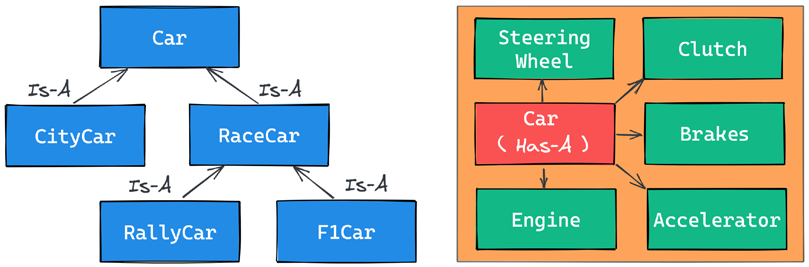

# Acceso a una clase base
Ya hemos visto declaraciones de clases, como $class ClassA: pass$ y $class ClassB(BaseClassName): pass$. Cuando no especificamos una clase base explícitamente, Python establecerá la clase objeto especial como clase base de la que estamos definiendo. En última instancia, todas las clases derivan de $object$. Recuerda que, si no especificas una clase base, los paréntesis son opcionales y en la práctica nunca se utilizan.

Por lo tanto, escribir $class A: pass$ o $class A(): pass$ o $class A(object): pass$ es exactamente lo mismo. La clase $object$ es una clase especial en el sentido de que alberga los métodos que son comunes a todas las clases de Python, y no te permite establecer ningún atributo sobre ella.

Veamos cómo podemos acceder a una clase base desde el interior de una clase:

In [16]:
class Book:
    def __init__(self, title, publisher, pages):
        self.title = title
        self.publisher = publisher
        self.pages = pages

class Ebook(Book):
    def __init__(self, title, publisher, pages, format_):
        self.title = title
        self.publisher = publisher
        self.pages = pages
        self.format_ = format_

Si revisas el código anterior, te darás cuenta que tres de los parámetros de entrada para $Book$ están duplicados en $Ebook$. Esto es una práctica bastante mala porque ahora tenemos dos conjuntos de instrucciones que están haciendo lo mismo. Además, cualquier cambio en la firma de `Book.__init__()` no se reflejará en $Ebook$. Sabemos que $Ebook$ $Is-A$ $Book$, y por tanto probablemente queramos que los cambios se reflejen en las clases hijas.

Veamos una forma de solucionar este problema:

In [18]:
class Book:
    def __init__(self, title, publisher, pages):
        self.title = title
        self.publisher = publisher
        self.pages = pages

class Ebook(Book):
    def __init__(self, title, publisher, pages, format_):
        Book.__init__(self, title, publisher, pages)
        self.format_ = format_

ebook = Ebook(
    'Learn Python Programming', 'Packt Publishing', 500, 'PDF')

print(f"{ebook.title = }")          # Learn Python Programming
print(f"{ebook.publisher = }")      # Packt Publishing
print(f"{ebook.pages = }")          # 500
print(f"{ebook.format_ = }")        # PDF

ebook.title = 'Learn Python Programming'
ebook.publisher = 'Packt Publishing'
ebook.pages = 500
ebook.format_ = 'PDF'


Ahora está mejor. Hemos eliminado esa desagradable duplicación. Básicamente, le decimos a Python que llame al método `__init__()` de la clase $Book$; alimentamos $self$ a esa llamada, asegurándonos de que vinculamos esa llamada a la instancia actual.

Si modificamos la lógica dentro del método `__init__()` de $Book$, no necesitamos tocar $Ebook$; se adaptará automáticamente al cambio.

Este enfoque es bueno, pero todavía podemos hacerlo un poco mejor. Digamos que cambiamos el nombre de $Book$ a $Liber$, porque nos hemos enamorado del latín. Entonces tendríamos que cambiar el método `__init__()` de $Ebook$ para reflejar ese cambio. Esto puede evitarse usando la palabra reservada `super`:

In [19]:
class Book:
    def __init__(self, title, publisher, pages):
        self.title = title
        self.publisher = publisher
        self.pages = pages

class Ebook(Book):
    def __init__(self, title, publisher, pages, format_):
        super().__init__(title, publisher, pages)
        # Otra forma de hacer lo mismo es:
        # super(Ebook, self).__init__(title, publisher, pages)
        self.format_ = format_

ebook = Ebook(
    'Learn Python Programming', 'Packt Publishing', 500, 'PDF')

print(f"{ebook.title = }")          # Learn Python Programming
print(f"{ebook.publisher = }")      # Packt Publishing
print(f"{ebook.pages = }")          # 500
print(f"{ebook.format_ = }")        # PDF

ebook.title = 'Learn Python Programming'
ebook.publisher = 'Packt Publishing'
ebook.pages = 500
ebook.format_ = 'PDF'


`super()` es una función que devuelve un objeto $proxy$ que delega las llamadas a métodos en una clase padre o hermana (tener en cuenta que dos clases son hermanas si comparten las mismas clases padres).

En este caso, `super()` delegará esa llamada a `__init__()` de la clase $Book$, y lo bueno de este enfoque es que ahora somos libres de cambiar $Book$ a $Liber$ sin tener que tocar la lógica en el método `__init__()` de $Ebook$.

Ahora que sabemos cómo acceder a una clase base desde su hija, vamos a explorar la herencia múltiple de Python.

# Herencia múltiple
Aparte de componer una clase utilizando más de una clase base, lo que interesa aquí es cómo se realiza una búsqueda de atributos. Eche un vistazo al siguiente diagrama:

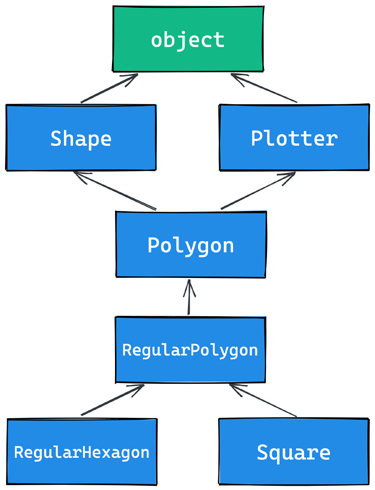

Como puedes ver, $Shape$ y $Plotter$ actúan como clases base para todas las demás. $Polygon$ hereda directamente de ellas, $RegularPolygon$ hereda de $Polygon$, y tanto $RegularHexagon$ como $Square$ heredan de $RegularPolygon$. Observe también que $Shape$ y $Plotter$ heredan implícitamente de $object$, por lo que tenemos lo que se conoce como un diamante o, en términos más simples, más de un camino para llegar a una clase base. Veremos por qué esto importa en unos momentos. Traduzcamos el diagrama a código:

In [20]:
class Shape:
    geometric_type = 'Generic Shape'
    
    def area(self):                 # This acts as placeholder for the interface
        raise NotImplementedError
    
    def get_geometric_type(self):
        return self.geometric_type

class Plotter:
    def plot(self, ratio, topleft):
        # Imagine some nice plotting logic here...
        print('Plotting at {}, ratio {}.'.format(
            topleft, ratio))

class Polygon(Shape, Plotter): # base class for polygons
    geometric_type = 'Polygon'

class RegularPolygon(Polygon): # Is-A Polygon
    geometric_type = 'Regular Polygon'
    
    def __init__(self, side):
        self.side = side

class RegularHexagon(RegularPolygon): # Is-A RegularPolygon
    geometric_type = 'RegularHexagon'
    
    def area(self):
        return 1.5 * (3 ** .5 * self.side ** 2)

class Square(RegularPolygon): # Is-A RegularPolygon
    geometric_type = 'Square'
    
    def area(self):
        return self.side * self.side

hexagon = RegularHexagon(10)
print(f"{hexagon.area() = }")               # 259.8076211353316
print(f"{hexagon.get_geometric_type() = }") # RegularHexagon
hexagon.plot(0.8, (75, 77))                 # Plotting at (75, 77), ratio 0.8.

square = Square(12)
print(f"{square.area() = }")                # 144
print(f"{square.get_geometric_type() = }")  # Square
square.plot(0.93, (74, 75))                 # Plotting at (74, 75), ratio 0.93.

hexagon.area() = 259.8076211353316
hexagon.get_geometric_type() = 'RegularHexagon'
Plotting at (75, 77), ratio 0.8.
square.area() = 144
square.get_geometric_type() = 'Square'
Plotting at (74, 75), ratio 0.93.


Revisando el código anterior: la clase $Shape$ tiene un atributo, $geometric_type$, y dos métodos: $area()$ y $get_geometric_type()$. Es bastante común utilizar clases base (como $Shape$, en nuestro ejemplo) para definir una interfaz, un conjunto de métodos para los que los hijos deben proporcionar una implementación. Hay diferentes y mejores maneras de hacer esto, pero queremos mantener este ejemplo lo más simple posible.

También tenemos la clase $Plotter$, que añade el método $plot()$, proporcionando así capacidades de trazado para cualquier clase que herede de ella. Por supuesto, la implementación de $plot()$ es sólo una impresión ficticia en este ejemplo. La primera clase interesante es $Polygon$, que hereda de $Shape$ y $Plotter$.

Hay muchos tipos de polígonos, uno de los cuales es el regular, que es a la vez equiangular (todos los ángulos son iguales) y equilátero (todos los lados son iguales), por lo que creamos la clase $RegularPolygon$ que hereda de $Polygon$. Para un polígono regular, donde todos los lados son iguales, podemos implementar un simple método `__init__()`, que sólo toma la longitud del lado. Creamos las clases $RegularHexagon$ y $Square$, que heredan de $RegularPolygon$.

Esta estructura es bastante larga, pero esperamos que te dé una idea de cómo especializar la clasificación de tus objetos cuando diseñes el código.

Ahora, por favor, eche un vistazo a las últimas ocho líneas. Observe que cuando llamamos al método $area()$ en el hexágono y el cuadrado, obtenemos el área correcta para ambos. Esto se debe a que ambos proporcionan la lógica de implementación correcta para ello. Además, podemos llamar a $get_geometric_type()$ en ambos, a pesar de que no está definido en sus clases, y Python tiene que ir hasta $Shape$ para encontrar una implementación para ello. Tenga en cuenta que, aunque la implementación se proporciona en la clase $Shape$, el $self.geometric_type()$ utilizado para el valor de retorno se toma correctamente de la instancia que llama.

Las llamadas al método $plot()$ también son interesantes y muestran cómo puedes enriquecer tus objetos con capacidades que de otra forma no tendrían. Esta técnica es muy popular en frameworks web como Django, que proporciona clases especiales llamadas $mixins$, cuyas capacidades puedes utilizar sin más. Todo lo que tienes que hacer es definir el $mixin$ deseado como una de las clases base para el tuyo propio, y ya está.

La herencia múltiple es poderosa, pero también puede ser muy complicada, así que tenemos que asegurarnos de que entendemos lo que pasa cuando la usamos.

## Orden de resolución del método
A estas alturas, sabemos que cuando preguntamos por algún atributo de objeto y este no se encuentra en ese objeto, Python empieza a buscar en la clase de la que se creó algún objeto. Si tampoco se encuentra allí, Python busca hacia arriba en la cadena de herencia hasta que se encuentra el atributo o se llega a la clase del objeto. Esto es bastante sencillo de entender si la cadena de herencia sólo está formada por pasos de herencia simple, lo que significa que las clases sólo tienen un padre, hasta llegar a $object$ (clase base). Sin embargo, cuando hay herencia múltiple, hay casos en los que no es sencillo predecir cuál será la siguiente clase que se buscará si no se encuentra un atributo.

Python proporciona una manera de saber siempre el orden en el que se buscan las clases en la búsqueda de atributos: el orden de resolución de métodos (MRO por sus siglás en inglés). El MRO es el orden en el que las clases base buscan un miembro durante la búsqueda. Desde la versión 2.3, Python utiliza un algoritmo llamado C3, que garantiza la monotonicidad.

En relación con el ejemplo anterior, veamos la MRO para la clase $Square$:

In [24]:
print(f"{square.__class__.__mro__ = }")

square.__class__.__mro__ = (<class '__main__.Square'>, <class '__main__.RegularPolygon'>, <class '__main__.Polygon'>, <class '__main__.Shape'>, <class '__main__.Plotter'>, <class 'object'>)


Para llegar a la MRO de una clase, podemos ir de la instancia a su `atributo __class__`, y de eso a su `atributo __mro__`. Alternativamente, podríamos haber utilizado `Square.__mro__`, o `Square.mro()` directamente, pero si tienes que hacerlo desde una instancia, tendrás que derivar su clase dinámicamente.

Observa que el único punto de duda es la bifurcación después de $Polygon$, donde la cadena de herencia se rompe en dos caminos: uno lleva a $Shape$ y el otro a $Plotter$.

Sabemos por el escaneo de la MRO para la clase $Square$ que $Shape$ se busca antes de $Plotter$. 

Para ver la importancia de ello, considere el siguiente código:

In [25]:
class A:
    label = 'a'

class B(A):
    label = 'b'

class C(A):
    label = 'c'

class D(B, C):
    pass

d = D()
print(f"{d.label = }")

d.label = 'b'


Tanto $B$ como $C$ heredan de $A$, y $D$ hereda tanto de $B$ como de $C$. Esto significa que la búsqueda del atributo $label$ puede llegar a la parte superior $(A)$ a través de $B$ o de $C$. Según a cuál se llegue primero, obtendremos un resultado diferente.

Así, en el ejemplo anterior, obtenemos $«b»$, que es lo que esperábamos, ya que $B$ es la que está más a la izquierda entre las clases base de $D$. Pero, ¿qué ocurre si eliminamos el atributo $label$ de $B$? Sería una situación confusa: ¿el algoritmo llegará hasta $A$ o llegará primero a $C$? Lo veremos a continuación:

In [27]:
class A:
    label = 'a'
class B(A):
    pass                            # was: label = 'b'
class C(A):
    label = 'c'
class D(B, C):
    pass
d = D()
print(f"{d.label = }")              # 'c'
print(f"{d.__class__.mro() = }")    # notice another way to get the MRO

d.label = 'c'
d.__class__.mro() = [<class '__main__.D'>, <class '__main__.B'>, <class '__main__.C'>, <class '__main__.A'>, <class 'object'>]


Con ello, aprendemos que el MRO es D-B-C-A-object, lo que significa que cuando pedimos $d.label$, obtenemos $'c'$, que es correcto.

En el día a día de la programación, no es común tener que lidiar con el *MRO*, pero nos pareció importante al menos mencionarlo en este párrafo para que, en caso de que te enredes en una compleja estructura de *mixins*, seas capaz de encontrar la manera de salir de ella.

# Clase y métodos estáticos
Hasta ahora, hemos codificado clases con atributos en forma de datos y métodos de instancia, pero hay otros dos tipos de métodos que podemos colocar dentro de una clase: métodos estáticos y métodos de clase.

## Métodos estáticos
Como recordarás, cuando creas un objeto de clase, Python le asigna un nombre. Ese nombre actúa como un espacio de nombres, y a veces tiene sentido agrupar funcionalidades bajo él. Los métodos estáticos son perfectos para este caso de uso. A diferencia de los métodos de instancia, no se les pasa ningún argumento especial, y por tanto no necesitamos crear una instancia de la clase para llamarlos. Veamos un ejemplo de una clase imaginaria $StringUtil$:

In [28]:
class StringUtil:
    @staticmethod
    def is_palindrome(s, case_insensitive=True):
        # we allow only letters and numbers
        s = ''.join(c for c in s if c.isalnum()) # Study this!
        # For case insensitive comparison, we lower-case s
        if case_insensitive:
            s = s.lower()
        for c in range(len(s) // 2):
            if s[c] != s[-c -1]:
                return False
        return True
    
    @staticmethod
    def get_unique_words(sentence):
        return set(sentence.split())

print(StringUtil.is_palindrome(
    'Radar', case_insensitive=False))           # False: Case Sensitive

print(StringUtil.is_palindrome(
    'A nut for a jar of tuna'))                 # True
print(StringUtil.is_palindrome(
    'Never Odd, Or Even!'))                     # True
print(StringUtil.is_palindrome(
    'In Girum Imus Nocte Et Consumimur Igni')   # Latin! Show-off!
)                                               # True
print(StringUtil.get_unique_words(
    'I love palindromes. I really really love them!'))

False
True
True
True
{'I', 'them!', 'palindromes.', 'really', 'love'}


El código anterior es bastante interesante. En primer lugar, aprendemos que los métodos estáticos se crean simplemente aplicándoles el decorador `staticmethod`. Puedes ver que no se les pasa ningún argumento especial, así que, aparte de la decoración, en realidad parecen funciones.

Tenemos una clase, $StringUtil$, que actúa como contenedor de funciones. Otro enfoque sería tener un módulo separado con funciones en el interior. Es realmente una cuestión de preferencia la mayor parte del tiempo.

La lógica dentro de *is_palindrome()* debería ser sencilla de entender a estas alturas, pero, por si acaso, vamos a repasarla. En primer lugar, eliminamos todos los caracteres de $s$ que no son ni letras ni números. Para ello, utilizamos el método $join()$ de un objeto cadena (en este caso, un objeto cadena vacío). Al llamar a $join()$ sobre una cadena vacía, el resultado es que todos los elementos del iterable que pasemos a $join()$ se concatenarán. Alimentamos $join()$ con una expresión generadora que dice que tome cualquier carácter de $s$ si el carácter es alfanumérico o un número. Esto se debe a que, en las sentencias palíndromas, queremos descartar cualquier cosa que no sea un carácter o un número.

A continuación, ponemos $s$ en minúsculas si $case_insensitive$ es $True$, y procedemos a comprobar si se trata de un palíndromo. Para ello, comparamos el primer y el último carácter, luego el segundo y el penúltimo, y así sucesivamente. Si en algún punto encontramos una diferencia, significa que la cadena no es un palíndromo, y por tanto podemos devolver $False$. Por otro lado, si salimos del bucle $for$ normalmente, significa que no se han encontrado diferencias, y por tanto podemos decir que la cadena es un palíndromo.

Observa que este código funciona correctamente independientemente de la longitud de la cadena; es decir, si la longitud es par o impar. La medida $len(s) // 2$ alcanza la mitad de $s$, y si $s$ tiene un número impar de caracteres, el del medio no se comprobará (por ejemplo, en $RaDaR$, $D$ no se comprueba), pero no nos importa; se compararía consigo mismo, así que siempre pasa esa comprobación.

El método *get_unique_words()* es mucho más sencillo: sólo devuelve un conjunto al que alimentamos una lista con las palabras de una frase. La clase set elimina cualquier duplicación por nosotros, así que no necesitamos hacer nada más.

La clase $StringUtil$ nos proporciona un bonito espacio de nombres contenedor para los métodos destinados a trabajar con cadenas. Podríamos haber codificado un ejemplo similar con una clase $MathUtil$, y algunos métodos estáticos para trabajar con números, pero este es una manera diferente de hacerlo.

## Métodos de clase
Los *métodos de clase* se diferencian ligeramente de los *métodos estáticos* en que, al igual que los métodos de instancia, también toman un primer argumento especial, pero en este caso, es el propio objeto de clase, en lugar de la instancia. Un caso de uso muy común para codificar métodos de clase es proporcionar capacidad de fábrica a una clase, lo que significa tener formas alternativas de crear instancias de la clase. Veamos un ejemplo:

In [1]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    @classmethod
    def from_tuple(cls, coords): # cls is Point
        return cls(*coords)

    @classmethod
    def from_point(cls, point): # cls is Point
        return cls(point.x, point.y)

p = Point.from_tuple((5, 9))
print(f"{p.x = }, {p.y = }")

q = Point.from_point(p)
print(f"{q.x = }, {q.y = }")

p.x = 5, p.y = 9
q.x = 5, q.y = 9


En el código anterior, mostramos cómo utilizar un *método de clase* para crear una fábrica para la clase. En este caso, queremos crear una instancia de $Point$ pasando ambas coordenadas (creación regular $p = Punto(3, 7)$), pero también queremos poder crear una instancia pasando una tupla (*Point.from_tuple*) u otra instancia (*Point.from_point*).

Dentro de cada *método de clase*, el argumento *cls* hace referencia a la clase *Point*. Al igual que con el *método de instancia*, que toma *self* como primer argumento, el *método de clase* toma un argumento *cls*. Tanto *self* como *cls* se nombran según una convención que no se está obligado a seguir pero que se recomienda encarecidamente respetar. Esto es algo que ningún programador profesional de Python cambiaría; es una convención tan fuerte que muchas herramientas, como analizadores sintácticos, linters y similares, confían en ella.

Las clases y los métodos estáticos funcionan bien juntos. Los métodos estáticos son en realidad muy útiles para romper la lógica de un método de clase para mejorar su diseño.

Veamos un ejemplo refactorizando la clase $StringUtil$:

In [2]:
class StringUtil: 
    @classmethod
    def is_palindrome(cls, s, case_insensitive=True):
        s = cls._strip_string(s)
        # For case insensitive comparison, we lower-case s
        if case_insensitive:
            s = s.lower()
        return cls._is_palindrome(s)

    @staticmethod
    def _strip_string(s):
        return ''.join(c for c in s if c.isalnum())

    @staticmethod
    def _is_palindrome(s):
        for c in range(len(s) // 2):
            if s[c] != s[-c -1]:
                return False
        return True

    @staticmethod
    def get_unique_words(sentence):
        return set(sentence.split())

print(StringUtil.is_palindrome('A nut for a jar of tuna')) # True
print(StringUtil.is_palindrome('A nut for a jar of beans')) # False

True
False


Compare este código con la versión anterior. En primer lugar, observa que aunque *is_palindrome()* es ahora un *método de clase*, lo llamamos de la misma forma que cuando era estático. La razón por la que lo cambiamos a un método de clase es que después de factorizar un par de piezas de lógica (*_strip_string* y *_is_palindrome*), necesitamos obtener una referencia a ellas, y si no tenemos *cls* en nuestro método, la única opción sería llamarlas usando el nombre de la propia clase, así: *StringUtil._strip_string(...)* y *StringUtil._is_palindrome(...)*, lo cual no es una buena práctica, ya que codificaríamos el nombre de la clase en el método *is_palindrome()*, poniéndonos en la situación de tener que modificarlo cada vez que queramos cambiar el nombre de la clase. Usar *cls* significa que actuará como el nombre de la clase, lo que significa que nuestro código no necesitará ninguna modificación si el nombre de la clase cambia.

Observa cómo la nueva lógica se lee mucho mejor que la versión anterior. Por otra parte, observe que, al nombrar los métodos factorizados con un guión bajo inicial, estamos dando a entender que esos métodos no deben ser llamados desde fuera de la clase, pero esto se verás más adelante.

# Métodos privados y manipulación de nombres
Si tienes conocimientos de lenguajes como Java, C# o C++, sabrás que permiten al programador asignar un estado de privacidad a los atributos (tanto datos como métodos). Cada lenguaje tiene su propio toque ligeramente diferente para esto, pero la esencia es que los atributos públicos son accesibles desde cualquier punto del código, mientras que los privados son accesibles sólo dentro del ámbito en el que se definen.

En Python, no existe tal cosa. Todo es público; por lo tanto, dependemos de convenciones y, para la privacidad, de un mecanismo llamado *name mangling*.

La convención es la siguiente: si el nombre de un atributo no tiene guiones bajos, se considera público. Esto significa que puedes acceder a él y modificarlo libremente. Cuando el nombre tiene un guión bajo inicial, el atributo se considera privado, lo que significa que probablemente está destinado a ser utilizado internamente y no se debe modificar, o llamarlo desde el exterior. Un caso de uso muy común para los atributos privados son los métodos de ayuda que se supone que van a ser usados por los públicos (posiblemente en cadenas de llamadas en conjunción con otros métodos), y datos internos, como factores de escala, o cualquier otro dato que idealmente pondríamos en una constante (una variable que no puede cambiar, pero, sorpresa, sorpresa, Python tampoco tiene de esas).

Esta característica suele asustar a la gente de otros entornos; se sienten amenazados por la falta tanto de privacidad como de restricciones. La llamada a la privacidad en realidad tiene sentido porque sin ella, te arriesgas a introducir bugs en tu código de verdad. Para entenderlo mejor, miremos el siguiente ejemplo:

In [15]:
class A:
    def __init__(self, factor):
        self._factor = factor

    def op1(self):
        print('Op1 with factor {}...'.format(self._factor))

class B(A):
    def op2(self, factor):
        self._factor = factor
        print('Op2 with factor {}...'.format(self._factor))

obj = B(156)
obj.op1()       # Op1 with factor 156...
obj.op2(86)     # Op2 with factor 86...
obj.op1()       # Op1 with factor 86... <- This is BAD

Op1 with factor 156...
Op2 with factor 86...
Op1 with factor 86...


Notar que tenemos un atributo llamado *_factor*, y vamos a pretender que es tan importante que no se modifica en tiempo de ejecución después de crear la instancia porque $op1()$ depende de él para funcionar correctamente. Lo hemos nombrado con un guión bajo inicial, pero el problema aquí es que cuando llamamos a $obj.op2(42)$, lo modificamos, y esto se refleja en las siguientes llamadas a $op1()$.

Arreglemos este comportamiento no deseado añadiendo otro guión bajo inicial:

In [12]:
class A:
    def __init__(self, factor):
        self.__factor = factor

    def op1(self):
        print('Op1 with factor {}...'.format(self.__factor))

class B(A):
    def op2(self, factor):
        self.__factor = factor
        print('Op2 with factor {}...'.format(self.__factor))

obj = B(156)
obj.op1()       # Op1 with factor 156...
obj.op2(86)     # Op2 with factor 86...
obj.op1()       # Op1 with factor 156... <- Wohoo! Now it's GOOD!

Op1 with factor 156...
Op2 with factor 86...
Op1 with factor 156...


Con la agregación del guión bajo adicional en *factor*, ahora funciona como se deseaba ya que lo que está pasando es que el mecanismo de manipulación de nombres se ha puesto en marcha.

La mezcla de nombres significa que cualquier nombre de atributo que tenga al menos dos guiones bajos al principio y como máximo un guión bajo al final, como *__my_attr*, es reemplazado por un nombre que incluya un guión bajo y el nombre de la clase antes del nombre real, como *_ClassName__my_attr*.

Esto significa que cuando se hereda de una clase, el mecanismo de manipulación da a su atributo privado dos nombres diferentes en las clases base e hija para evitar la colisión de nombres. Cada objeto de clase e instancia almacena referencias a sus atributos en un atributo especial llamado `__dict__`, así que vamos a inspeccionar `obj.__dict__` para ver la manipulación de nombres en acción:

In [13]:
print(obj.__dict__.keys())

dict_keys(['_A__factor', '_B__factor'])


`obj` tiene ahora dos atributos, `_A__factor` (manipulado dentro de la clase A), y `_B__factor` (manipulado dentro de la clase B). Este es el mecanismo que asegura que cuando haces `obj.__factor = 86`, `__factor` en $A$ no se cambia porque en realidad estás tocando `_B__factor`, lo que deja `_A__factor` sano y salvo.

Esto es conveniente si estás diseñando una librería con clases que están destinadas a ser usadas y extendidas por otros desarrolladores, ya que necesitarás tener esto en cuenta para evitar el `overriding` no intencionado de tus atributos. Errores como estos pueden ser bastante sutiles y difíciles de detectar.

# El decorador de propiedades
Un punto de interés en Python es el *decorador de propiedades*. Imagina que tienes un atributo de edad en una clase *Person* y, en algún momento, quieres asegurarte de que cuando cambias su valor, también estás comprobando que la edad está dentro de un rango adecuado, como [18, 99]. Para ello, podrías escribir métodos de acceso, como *get_age()* y *set_age(...)* (también llamados *getters* y *setters*), y poner la lógica allí. *get_age()* probablemente sólo devolverá la edad, mientras que *set_age(...)* establecerá su valor después de comprobar su validez. El problema es que puede que ya tengas un montón de código accediendo directamente al atributo *age*, lo que significa que ahora tienes que hacer una tediosa refactorización. Lenguajes como Java superan este problema utilizando el patrón accessor básicamente por defecto. Muchos Entornos de Desarrollo Integrado (IDEs) de Java autocompletan una declaración de atributo escribiendo métodos getter y setter accessor por ti sobre la marcha.

Python es más inteligente y hace esto con el *decorador de propiedades*. Cuando decoras un método con una propiedad, puedes usar el nombre del método como si fuera un atributo de datos. Debido a esto, siempre es mejor evitar poner lógica que tardaría en completarse en tales métodos porque, al acceder a ellos como atributos, no esperamos tener que esperar.

Veamos un ejemplo:

In [18]:
class Person:
    def __init__(self, age):
        self.age = age # anyone can modify this freely

class PersonWithAccessors:
    def __init__(self, age):
        self._age = age

    def get_age(self):
        return self._age

    def set_age(self, age):
        if 18 <= age <= 99:
            self._age = age
        else:
            raise ValueError('Age must be within [18, 99]')

class PersonPythonic:
    def __init__(self, age):
        self._age = age

    @property
    def age(self):
        return self._age

    @age.setter
    def age(self, age):
        if 18 <= age <= 99:
            self._age = age
        else:
            raise ValueError('Age must be within [18, 99]')
        
person = PersonPythonic(45)
print(person.age)   # 45 - Notice we access as data attribute
person.age = 60     # Notice we access as data attribute
print(person.age)   # 60
try:
    person.age = 102    # ValueError: Age must be within [18, 99]
except ValueError as e:
    print(e)


45
60
Age must be within [18, 99]


La clase *Person* puede ser la primera versión que escribamos. Entonces nos damos cuenta de que necesitamos poner la lógica de rango en su lugar, así que, con otro lenguaje, tendríamos que reescribir *Person* como la clase *PersonWithAccessors*, y refactorizar todo el código que estaba usando *Person.age*. En Python, reescribimos *Person* como *PersonPythonic* (normalmente no cambiarías el nombre, por supuesto) de forma que la edad se almacena en una variable privada *_age*, y definimos las propiedades getters y setters usando la decoración mostrada, lo que nos permite seguir usando las instancias de persona como hacíamos antes. Un *getter* es un método que se llama cuando accedemos a un atributo para leerlo. Por otro lado, un *setter* es un método que se llama cuando accedemos a un atributo para escribirlo. En otros lenguajes, como Java, es habitual definirlos como *get_age()* y *set_age(int value)*, pero la sintaxis de Python nos parece mucho más ordenada. Te permite empezar a escribir código simple y refactorizarlo más tarde, sólo cuando lo necesites; no hay necesidad de contaminar tu código con accessors sólo porque puedan ser útiles en el futuro.

El *decorador de propiedades* también permite datos de sólo lectura (al no escribir la contrapartida setter) como el siguiente ejemplo:

In [19]:
class Circle:
    def __init__(self, radius):
        self._radius = radius

    @property
    def radius(self):
        return self._radius

    @property
    def area(self):
        return 3.14159 * (self._radius ** 2)

# Usage
circle = Circle(5)
print(circle.radius)  # Output: 5
print(circle.area)    # Output: 78.53975

try:
    circle.radius = 10
except AttributeError as e:
    print(e)           # Attempting to modify the radius will raise an AttributeError

5
78.53975
property 'radius' of 'Circle' object has no setter


El decorador `@property` se utiliza para hacer que los atributos *radius* y *area* sean de solo lectura. Esto quiere decir, que se puede acceder al atributo *radius*, pero no se puede modificar directamente fuera de la clase. Cualquier intento de establecer $circulo.radio = 10$ resultará en un $AttributeError$ porque no se ha definido un método *setter* para radio.

Otra cualidad importante del *decorador de propiedades* es cuando se elimina un atributo, como en el siguiente ejemplo:

In [20]:
# Using __delattr__:
class MyClass1:
    def __init__(self, value):
        self.value = value

    def __delattr__(self, name):
        if name == "value":
            print(f"Deleting attribute '{name}'")
        super().__delattr__(name)

# Usage
obj = MyClass1(10)
print(obj.value)  # Output: 10
del obj.value     # Output: Deleting attribute 'value'

# Using a Property with a Deleter:
class MyClass2:
    def __init__(self, value):
        self._value = value

    @property
    def value(self):
        return self._value

    @value.deleter
    def value(self):
        print("Deleting the value attribute")
        del self._value

# Usage
obj = MyClass2(10)
print(obj.value)  # Output: 10
del obj.value     # Output: Deleting the value attribute

10
Deleting attribute 'value'
10
Deleting the value attribute


En el primer caso, el método `__delattr__` se llama cuando usas la instrucción `del` para eliminar un atributo. Te permite definir un comportamiento personalizado cuando se elimina cualquier atributo En cambio, usando una *Propiedad* con un *"Deleter"*, El decorador `@property` se combina con `@property.deleter` para definir una acción personalizada cuando se elimina la propiedad. Esto es más específico para ese atributo en particular.

En ambos casos, cuando se ejecuta del `obj.value`, se imprime un mensaje personalizado para indicar que se está eliminando el atributo.

# El decorador cached_property
Un uso conveniente de las propiedades es cuando necesitamos ejecutar algún código para configurar el objeto que queremos utilizar. Por ejemplo, supongamos que necesitamos conectarnos a una base de datos (o a una API).

En ambos casos, puede que tengamos que configurar un objeto cliente que sepa cómo hablar con la base de datos (o con la API). Es bastante común usar una propiedad, en estos casos, para que podamos ocultar la complejidad de tener que configurar el cliente, y podamos simplemente usarlo. Veamos un ejemplo simplificado:

In [1]:
class Client:
    def __init__(self):
        print("Setting up the client...")

    def query(self, **kwargs):
        print(f"Performing a query: {kwargs}")

class Manager:
    @property
    def client(self):
        return Client()
    
    def perform_query(self, **kwargs):
        return self.client.query(**kwargs)

En el ejemplo anterior, tenemos una clase *Client* ficticia, que imprime la cadena «Configurando el cliente...» cada vez que creamos una nueva instancia. También tiene un método de consulta ficticio, que imprime una cadena también. Luego tenemos una clase, *Manager*, que tiene una propiedad *Client*, que crea una nueva instancia de Client cada vez que es llamada (por ejemplo, por una llamada a *perform_query*).

Si ejecutáramos este código, observaríamos que cada vez que llamamos a *perform_query* en el gestor, vemos que se imprime la cadena «Setting up the client...». Cuando la creación de un cliente es costosa, este código estaría desperdiciando recursos, por lo que sería mejor almacenar en caché ese cliente, de la siguiente manera:

In [2]:
class ManualCacheManager:
    @property
    def client(self):
        if not hasattr(self, '_client'):
            self._client = Client()
        return self._client

La clase *ManualCacheManager* es un poco más inteligente: la propiedad cliente comprueba primero si el atributo *_client* está en la clase, llamando a la función *hasattr* incorporada. Si no, asigna *_client* a una nueva instancia de *Client*. Finalmente, simplemente lo devuelve. Acceder repetidamente a la propiedad cliente de esta clase sólo creará una instancia de *Client*, la primera vez. A partir de la segunda llamada, *_client* se devuelve sin necesidad de crear una nueva.

Esta es una necesidad tan común que, en Python 3.8, el módulo *functools* añadió el decorador *cached_property*. Lo bueno de usar eso, en lugar de nuestra solución manual, es que en caso de que necesitemos refrescar el cliente, podemos simplemente borrar la propiedad cliente, y la próxima vez que lo llamemos, nos recreará un *Client* completamente nuevo. Veamos un ejemplo:

In [3]:
from functools import cached_property

class CachedPropertyManager:
    @cached_property
    def client(self):
        return Client()

    def perform_query(self, **kwargs):
        return self.client.query(**kwargs)

manager = CachedPropertyManager()               # New Client
manager.perform_query(object_id=42)             # first query
manager.perform_query(name_ilike='%Python%')    # second que
del manager.client                              # This causes a new Client on next call
manager.perform_query(age_gte=18)               # Third query

Setting up the client...
Performing a query: {'object_id': 42}
Performing a query: {'name_ilike': '%Python%'}
Setting up the client...
Performing a query: {'age_gte': 18}


Como puedes ver, sólo después de borrar manualmente el *manager.client* obtenemos uno nuevo cuando volvemos a invocar *manager.perform_query*.

Python 3.9 también introduce un decorador de caché, que puede usarse junto con el decorador de propiedades, para cubrir escenarios para los que *cached_property* no es adecuado. Un ejemplo de ello es el siguiente:

In [4]:
import functools

def cache(func):
    """Un decorador simple para almacenar en caché los resultados de una función."""
    @functools.wraps(func)
    def wrapper(self):
        if func.__name__ not in self._cache:
            self._cache[func.__name__] = func(self)
        return self._cache[func.__name__]
    return wrapper

class MiClase:
    def __init__(self, valor):
        self.valor = valor
        self._cache = {}

    @property
    @cache
    def calcular(self):
        print("Calculando valor...")
        return self.valor ** 2

# Uso
obj = MiClase(10)
print(obj.calcular)  # Primera llamada: Calculando valor... seguido de 100
print(obj.calcular)  # Segunda llamada: 100 (no recalcula, usa el valor en caché)


Calculando valor...
100
100


Donde, el decorador de cache almacena en caché el resultado de la función decorada. Verifica si el resultado ya está almacenado en un diccionario (*self._cache*). Si no está, calcula y almacena el resultado. La clase MiClase contiene un atributo valor y un diccionario *_cache* donde se almacenan los resultados cacheados y el método calcular es una propiedad que usa el decorador cache. La primera vez que se accede a calcular, realiza la operación y almacena el resultado. En las siguientes llamadas, devuelve el resultado almacenado sin recalcular.

Tener en cuenta, el decorador `@functools.wraps(func)` se utiliza en Python para preservar la información original de una función cuando esta es decorada. Cuando creas un decorador, es común que la función decorada pierda algunos de sus atributos originales, como su nombre, cadena de documentación (`__doc__`), y otras propiedades. Esto puede dificultar el proceso de depuración y la inspección de la función.

El decorador `@functools.wraps(func)` se asegura de que la función decorada retenga estos atributos. Se aplica al propio decorador y copia la información de la función original a la función decorada.

# Sobrecarga de operadores
El enfoque de Python sobre la sobrecarga de operadores nos parece brillante. Sobrecargar un operador significa darle un significado según el contexto en el que se utilice. Por ejemplo, el operador $+$ significa suma cuando tratamos con números, pero concatenación cuando tratamos con secuencias.

En Python, cuando utilizas operadores, lo más probable es que estés llamando a los métodos especiales de algunos objetos entre bastidores. Por ejemplo, la llamada $a[k]$ en un diccionario se traduce aproximadamente como `type(a).__getitem__(a, k)`. Podemos anular estos métodos especiales para nuestros propósitos.

Como ejemplo, vamos a crear una clase que almacene una cadena y evalúe si '42' es parte de esa cadena ($True$), y $False$ en caso contrario. Además, vamos a dar a la clase una propiedad de longitud que corresponde a la de la cadena almacenada:

In [ ]:
class Weird:
    def __init__(self, s):
        self._s = s

    def __len__(self):
        return len(self._s)

    def __bool__(self):
        return '42' in self._s

weird = Weird('Hello! I am 9 years old!')
print(f"{len(weird) = }")                       # 24
print(f"{bool(weird) = }")                      # False

weird2 = Weird('Hello! I am 42 years old!')
print(f"{len(weird2) = }")                       # 25
print(f"{bool(weird2) = }")                      # True

Para ver la lista completa de métodos mágicos que puedes sobrescribir para proporcionar tu implementación personalizada de operadores para tus clases, consulta la documentación oficial de Python.

# Polimorfismo: breve descripción
La palabra polimorfismo viene del griego $polys$ (muchos, mucho) y $morphē$ (forma, figura), y su significado es la provisión de una única interfaz para entidades de distintos tipos.

En nuestro ejemplo del coche, llamamos a *engine.start()*, independientemente del tipo de motor que sea. Mientras exponga el método *start*, podemos llamarlo. Eso es polimorfismo en acción.

En otros lenguajes, como Java, para dar a una función la capacidad de aceptar diferentes tipos y llamar a un método en ellos, esos tipos necesitan ser codificados de tal manera que compartan una interfaz. De esta forma, el compilador sabe que el método estará disponible independientemente del tipo del objeto que recibe la función (siempre que extienda la interfaz específica, por supuesto).

En Python, las cosas son diferentes. El polimorfismo es implícito, y nada te impide llamar a un método en un objeto; por lo tanto, técnicamente, no hay necesidad de implementar interfaces u otros patrones.

Hay un tipo especial de polimorfismo llamado polimorfismo ad hoc, que es lo que vimos en la sobrecarga de operadores. Se trata de la capacidad de un operador para cambiar de forma según el tipo de datos que recibe.

El polimorfismo también permite a los programadores de Python utilizar simplemente la interfaz (métodos y propiedades) expuesta de un objeto en lugar de tener que comprobar de qué clase fue instanciado. Esto permite que el código sea más compacto y parezca más natural.

# Clases de datos
Antes de abandonar el ámbito de la programación orientada a objetos, hay una última cosa que queremos mencionar: las clases de datos. Introducidas en Python 3.7 por PEP 557, pueden describirse como tuplas con nombre mutables con valores por defecto. Pasemos directamente a un ejemplo para entenderlo mejor:

In [7]:
from dataclasses import dataclass

@dataclass
class Body:
    '''Class to represent a physical body.'''
    name: str
    mass: float = 0.    # Kg
    speed: float = 1.   # m/s
    
    def kinetic_energy(self) -> float:
        return (self.mass * self.speed ** 2) / 2

body = Body('Ball', 19, 3.1415)
print(f"{body.kinetic_energy() = }")    # 93.755711375 Joule
print(f"{body = }")                     # Body(name='Ball', mass=19, speed=3.1415)

body.kinetic_energy() = 93.755711375
body = Body(name='Ball', mass=19, speed=3.1415)


En el código anterior, hemos creado una clase para representar un cuerpo físico ($Body$), con un método que nos permite calcular su energía cinética (utilizando la conocida fórmula $E_k = \frac{1}{2}mv^2$). Fíjate en que el nombre se supone que es un *str*, mientras que la masa y la velocidad son *float*, y a ambas se les da un valor por defecto. También es interesante que no hayamos tenido que escribir ningún método `__init__()`; lo hace por nosotros el decorador `dataclass`, junto con métodos para comparar y para producir la representación en cadena del objeto (llamada implícita en la última línea por *print*).

Para mayor información, se puede leer todas las especificaciones en PEP 557.Lo importante es que las clases de datos pueden ofrecer una alternativa más agradable y ligeramente más potente a las tuplas con nombre, en caso de que lo necesites.

# Escribir un iterador personalizado
Ahora tenemos todas las herramientas para apreciar cómo podemos escribir nuestro propio iterador personalizado.

Definamos primero que es un iterable y un iterador:
- **Iterable:** Se dice que un objeto es iterable si es capaz de devolver sus miembros de uno en uno. Las listas, tuplas, cadenas y diccionarios son iterables. Los objetos personalizados que definen cualquiera de los métodos `__iter__()` o `__getitem__()` también son iterables.
- **Iterador:** Se dice que un objeto es un iterador si representa un flujo de datos. Un iterador personalizado debe proporcionar una implementación para el método `__iter__()` que devuelve el propio objeto, y una implementación para el método `__next__()` que devuelve el siguiente elemento del flujo de datos hasta que el flujo se agota, momento en el que todas las llamadas sucesivas a `__next__()` simplemente lanzan la excepción `StopIteration`. Las funciones incorporadas, como `iter()` y `next()`, son mapeadas para llamar a los métodos `__iter__()` y `__next__()` en un objeto, entre bastidores.

Escribamos un iterador que devuelva primero todos los caracteres impares de una cadena y luego los pares:

In [10]:
class OddEven:
    def __init__(self, data):
        self._data = data
        self.indexes = (list(range(0, len(data), 2)) + 
            list(range(1, len(data), 2)))

    def __iter__(self):
        return self

    def __next__(self):
        if self.indexes:
            return self._data[self.indexes.pop(0)]
        raise StopIteration

oddeven = OddEven('ThIsIsCoOl!')
print(f"{''.join(c for c in oddeven) = }")          # TIICO!hssol

oddeven = OddEven('CiAo')                   # or manually...
it = iter(oddeven)                          # this calls oddeven.__iter__ internally
print(f"{next(it) = }")                     # C
print(f"{next(it) = }")                     # A
print(f"{next(it) = }")                     # i
print(f"{next(it) = }")                     # o

''.join(c for c in oddeven) = 'TIICO!hssol'
next(it) = 'C'
next(it) = 'A'
next(it) = 'i'
next(it) = 'o'


Así que necesitábamos una implementación para `__iter__()` que devolviera el objeto en sí, y otra para `__next__()`. Vamos a repasarlo. Lo que hay que hacer es devolver *_datos[0], _datos[2], _datos[4], ..., _datos[1], _datos[3], _datos[5], ...* hasta que hayamos devuelto todos los elementos de los datos. Para ello, preparamos una lista de índices, como [0, 2, 4, 6, ..., 1, 3, 5, ...], y mientras haya al menos un elemento en ella, saltamos el primero y devolvemos el elemento de los datos que esté en esa posición, consiguiendo así nuestro objetivo. Cuando indexes está vacío, lanzamos `StopIteration`, como requiere el protocolo de iteradores.

Otra forma de hacerlo es la siguiente:

In [12]:
class OddEven:
    def __init__(self, data):
        if not isinstance(data, (str, list, tuple)):
            raise ValueError("El dato debe ser una cadena, lista o tupla.")
        self._data = data
        self.indexes = list(range(0, len(data), 2)) + list(range(1, len(data), 2))
        self._current_index = 0

    def __iter__(self):
        return self

    def __next__(self):
        if self._current_index < len(self.indexes):
            result = self._data[self.indexes[self._current_index]]
            self._current_index += 1
            return result
        raise StopIteration

# Ejemplo de uso
oddeven = OddEven('ThIsIsCoOl!')
print(f"{''.join(c for c in oddeven) = }")  # TIICO!hssol

oddeven = OddEven('CiAo')
it = iter(oddeven)
print(f"{next(it) = }")  # C
print(f"{next(it) = }")  # A
print(f"{next(it) = }")  # i
print(f"{next(it) = }")  # o

# Casos de prueba
test_cases = [
    '',          # Secuencia vacía
    'A',         # Secuencia con 1 elemento
    'AB',        # Secuencia con 2 elementos
    'ABC',       # Secuencia con 3 elementos
    'ABCD',      # Secuencia con 4 elementos
    'ABCDE',     # Secuencia con 5 elementos
]

for test in test_cases:
    oddeven = OddEven(test)
    result = ''.join(c for c in oddeven)
    print(f"Input: '{test}' -> Output: '{result}'")

''.join(c for c in oddeven) = 'TIICO!hssol'
next(it) = 'C'
next(it) = 'A'
next(it) = 'i'
next(it) = 'o'
Input: '' -> Output: ''
Input: 'A' -> Output: 'A'
Input: 'AB' -> Output: 'AB'
Input: 'ABC' -> Output: 'ACB'
Input: 'ABCD' -> Output: 'ACBD'
Input: 'ABCDE' -> Output: 'ACEBD'


En este nuevo código, hemos añadido dos puntos importantes. El primero es la validación de entrada que verifica que el tipo de data sea una cadena, lista o tupla, lanzando una excepción si no lo es. El segundo es la utilización un índice interno (*_current_index*) en lugar de modificar *indexes* en cada iteración. Esto permite que el objeto *OddEven* sea reutilizable para múltiples iteraciones sin necesidad de reconstruir indexes o instanciar el objeto nuevamente.